In [3]:
%load_ext autoreload
%autoreload 2
import main
import glob
import os
import pickle
import pandas
import torch
from torch import autograd

import helpers
import defaults
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt

In [6]:
args = main.config()
arg_files = glob.glob(os.path.join(args.storedir, '**/args.txt'), recursive=True)
exp_dirs = [os.path.dirname(f) for f in arg_files]

In [27]:
from tqdm.auto import tqdm

variables = ['lr1','lr2']
outputs = ['test_accuracy','adv_accuracy']

exp_dir = exp_dirs[0]
epoch=14

# change this
kwargs = helpers.load_dict(os.path.join(exp_dir, defaults.ARG_FILE))
kwargs['adv_epsilon'] = 10
args = main.config(**kwargs)
(train_loader, test_loader), device = main.load(args)
models, _ = main.init(args, device, shape=train_loader.shape)
checkpoints = [os.path.join(exp_dir, f'save{epoch:03d}.pt'),
               os.path.join(exp_dir, f'save_perturb{epoch:03d}.pt')]
for m,c in zip(models, checkpoints):
    m.load_state_dict(torch.load(c))

model, perturb = models
model.to(device)
perturb.to(device)
iterator = tqdm(enumerate(test_loader), total=len(test_loader))
correct = 0
adv_correct = 0
for idx, (data, target) in iterator:
    data, target = data.to(device), target.to(device)
    perturb = torch.tensor(torch.zeros(*test_loader.shape), requires_grad=True, device=device)
    output = model(data + perturb)
    loss = F.nll_loss(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    
    Dperturb_loss = autograd.grad(loss, perturb)[0]
    
    adv_output = model(data + args.adv_epsilon*Dperturb_loss)
    adv_pred = adv_output.argmax(dim=1, keepdim=True)
    adv_correct += adv_pred.eq(target.view_as(adv_pred)).sum().item()
    
    desc = (f'Test (adv) | Loss: {loss:10.3f}, {correct}/{len(test_loader.dataset)})')

accuracy = correct/len(test_loader.dataset)
adv_accuracy = adv_correct/len(test_loader.dataset)
# out = {}
# for v in variables:
#     out[v] = kwargs[v]
# for o in outputs:
#     out[o] = result[o]
accuracy,adv_accuracy

/home/ben/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(0.9843, 0.9854)

(0.9843, 0.9854)

In [5]:
torch.autograd

<module 'torch.autograd' from '/home/ben/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py'>

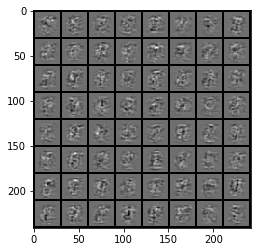

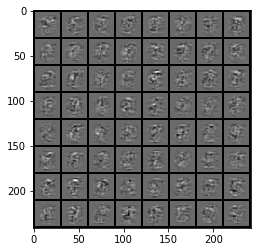

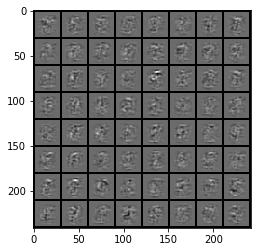

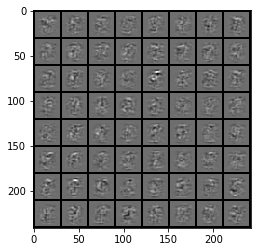

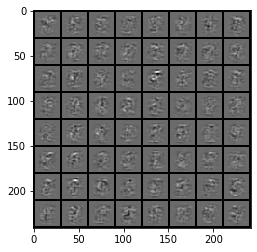

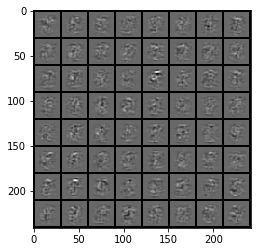

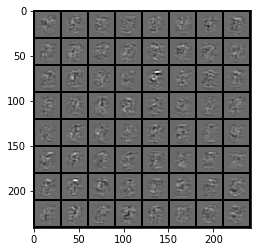

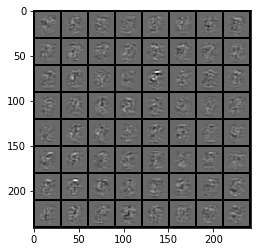

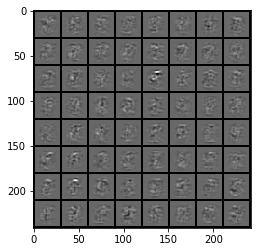

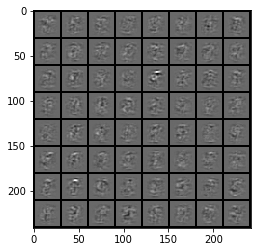

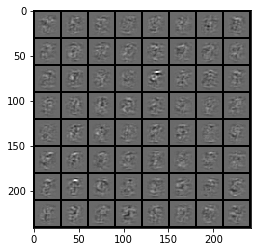

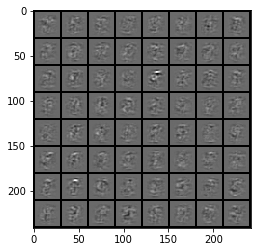

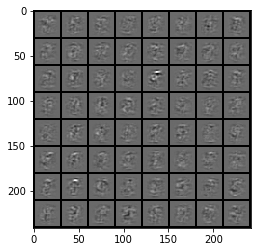

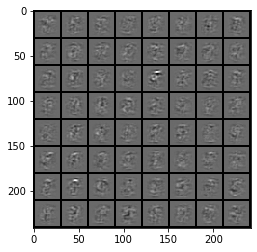

In [118]:
import torchvision

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



exp_dir = exp_dirs[4]


for i in range(14):
    args = main.config(**kwargs)
    (m,p),_ = main.init(args, 'cpu', [64,1,28,28])
    savefile = os.path.join(exp_dir, f'save_perturb{i+1:03d}.pt')
    p.load_state_dict(torch.load(savefile))
    delta = [_ for _ in p.parameters()][0]
    show(torchvision.utils.make_grid(delta, normalize=True))
    plt.show()

In [ ]:
import torch
m.load_state_dict(torch.load(savefile))

In [14]:
import numpy as np
np.random.rand(2)

array([0.97809459, 0.16387062])

In [86]:
delta

Parameter containing:
tensor([[[[-2.3910e-04,  2.1978e-04,  4.6093e-05,  ...,  3.0479e-04,
            8.4069e-04,  7.0353e-04],
          [-2.9664e-04, -1.8451e-04,  1.2491e-04,  ...,  1.3783e-03,
            1.1761e-03,  7.2949e-04],
          [-5.6721e-04,  8.0312e-04,  7.9174e-04,  ...,  2.1932e-03,
            1.7966e-04,  1.8806e-04],
          ...,
          [-1.4884e-04, -1.5887e-05, -1.6567e-03,  ..., -1.9850e-04,
            4.1209e-05,  2.2088e-04],
          [-1.9726e-04, -5.9020e-04, -1.0238e-03,  ..., -3.0569e-04,
           -5.4219e-05,  7.9958e-05],
          [-5.7057e-05,  4.5035e-05,  2.2980e-05,  ..., -7.4481e-05,
            1.4936e-04, -3.4156e-05]]],


        [[[-2.3141e-04, -4.9542e-04, -2.9886e-04,  ..., -1.4751e-04,
            8.3437e-05,  9.5984e-05],
          [-1.5449e-04, -1.2994e-03, -1.3567e-03,  ...,  4.9963e-04,
            8.9441e-05,  6.3273e-05],
          [ 3.8349e-04,  1.4812e-04, -2.7032e-04,  ...,  1.7633e-03,
            6.9852e-05, -3.7473e-0